# Example Workflow with spatialproteomics
Welcome to spatialproteomics! In this notebook, we will go through an example workflow by looking at the following steps:
1. Reading in a highly multiplexed image and creating a spatialproteomics object
2. Performing basic image processing steps to boost the signal-to-noise ratio
3. Performing cell segmentation using _StarDist_
4. Quantifying protein expression per cell
5. Predicting cell types with a simple argmax technique
6. Plotting the results

In [1]:
%load_ext autoreload
%autoreload 2

import spatialproteomics as sp
from skimage.io import imread
import matplotlib.pyplot as plt
from scipy.signal import medfilt2d

## 1. Getting Started

Before we can get started with _spatialproteomics_, we first need to read in the image. This can be done with the _skimage_ or _tifffile_ libraries.

In [2]:
# reading in the image and displaying its shape
image = imread('../../data/input.tiff')
image.shape

(5, 500, 500)

We can see that our image has 5 channels and has a size of 500 by 500 pixels. Next, we want to create a _spatialproteomics_ object and store the image within the object. To do this, we also need to feed in the names of the channels.

In [3]:
sp_object = sp.load_image_data(image, channel_coords=['DAPI', 'CD4', 'CD8', 'FOXP3', 'BCL6'])

`sp.load_image_data` returns an xarray object that we can simply inspect by calling in an jupyter cell. Note that the image is stored as the data variable `_image`.

In [4]:
sp_object

<xarray.Dataset>
Dimensions:   (channels: 5, y: 500, x: 500)
Coordinates:
  * channels  (channels) <U5 'DAPI' 'CD4' 'CD8' 'FOXP3' 'BCL6'
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Data variables:
    _image    (channels, y, x) uint16 10816 12359 14504 10965 ... 147 129 149 59

## 2. Image Processing
Highly multiplexed fluorescence imaging techniques frequently suffer from poor signal-to-noise ratio. To alleviate this problem, you can threshold out low intensity pixels, thereby boosting the contrast of the image. While there are automated methods to determine the thresholds for such operations, it is difficult to come up with one that works in all cases. Here, we therefore set the thresholds based on manual inspection.

Let's start by looking at the data set in the current form.

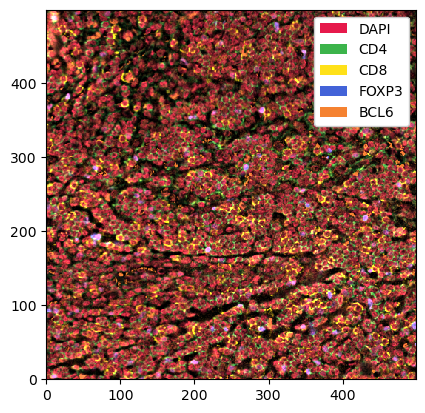

In [5]:
_ = sp_object.pl.show()  # pl: the plotting module

This is a bit much to look at. First, we want to check only the DAPI channel, to get a feel for the signal-to-noise ratio.

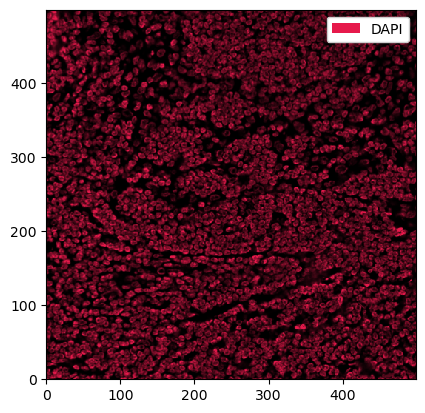

In [6]:
_ = sp_object.pp['DAPI'].pl.show()  # we can use pp[channels] to subset the spatialproteomics object

This looks promising. What about the other channels?

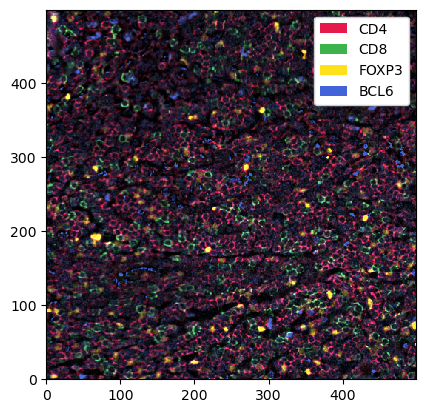

In [7]:
_ = sp_object.pp[['CD4', 'CD8', 'FOXP3', 'BCL6']].pl.show() # pp: the preprocessing module

Looking good, but we can make the signal a bit clearer by performing some image processing. In the following codeblock, we first threshold the channels by some percentile (so every value below that percentile gets set to 0). We then apply a 2D median filter with a kernel size of 3 to apply some smoothing.

In [8]:
# the percentiles by which the channels will be thresholded
percentiles = [0.2, 0.6, 0.6, 0.6, 0.6]

# thresholding and smoothing the data
sp_object = sp_object.pp.threshold(percentiles).pp.apply(medfilt2d, kernel_size=3)

Let's plot the new object.

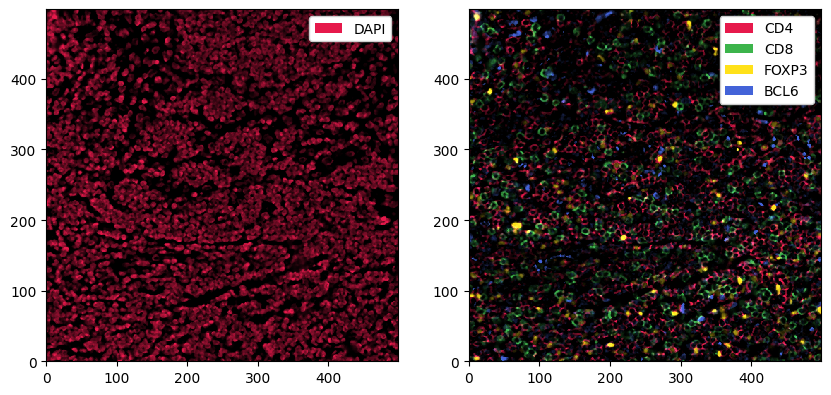

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
_ = sp_object.pp['DAPI'].pl.show(ax=ax[0])
_ = sp_object.pp[['CD4', 'CD8', 'FOXP3', 'BCL6']].pl.show(ax=ax[1])

## 3. Cell Segmentation

Great, this is our preprocessing done. Next, we can perform cell segmentation. Since we only have a universal nuclear marker at hand (and no universal membrane marker), we will segment the nuclei and then simply extend the segmentation masks by two pixels in every direction. We are going to use _cellpose_ for this purpose, which is implemented in the tool (tl) module.

In [10]:
sp_object = sp_object.tl.cellpose(channel='DAPI')

TORCH CUDA version not installed/working.
>>>> using CPU
>> cyto3 << model set to be used
>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
channels set to [0, 0]
~~~ ESTIMATING CELL DIAMETER(S) ~~~
estimated cell diameter(s) in 100.42 sec
>>> diameter(s) = 
[ 9.90 ]
~~~ FINDING MASKS ~~~
>>>> TOTAL TIME 246.03 sec


Looking at the object, you will realize that a new layer called `_cellpose_segmentation` has appeared. Before we can do anything with this information, we need to tell `spatialproteomics` that this should be treated as the main segmentation from now on. We do this via the `pp.add_segmentation()` function. This will cause a new layer called `_segmentation` to appear, which we can use for downstream analysis and visualization.

In general, after using a segmentation method from the `tl` module, you always need to call `pp.add_segmentation()` afterwards. The reason for this is that we later want to keep track of things like cell position, cell size etc. To ensure that these are always synchronized to our segmentation, we need to let `spatialproteomics` know which segmentation to treat as the main one.

In [11]:
sp_object = sp_object.pp.add_segmentation('_cellpose_segmentation')
sp_object

<xarray.Dataset>
Dimensions:                 (channels: 5, y: 500, x: 500, cells: 1335,
                             features: 2)
Coordinates:
  * channels                (channels) <U5 'DAPI' 'CD4' 'CD8' 'FOXP3' 'BCL6'
  * y                       (y) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * x                       (x) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * cells                   (cells) int64 1 2 3 4 5 ... 1331 1332 1333 1334 1335
  * features                (features) <U10 'centroid-0' 'centroid-1'
Data variables:
    _image                  (channels, y, x) float64 0.0 9.602e+03 ... 0.0 0.0
    _cellpose_segmentation  (y, x) uint16 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    _segmentation           (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    _obs                    (cells, features) float64 1.538 40.88 ... 262.0

We can plot this segmentation over the DAPI channel to see what exactly _cellpose_ did. We can zoom in a little bit to get a clearer picture.

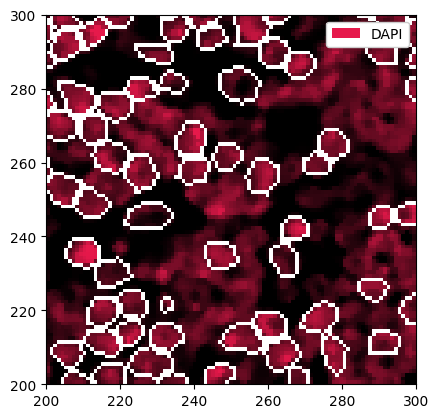

In [12]:
_ = sp_object.pp['DAPI'].pp[200:300, 200:300].pl.show(render_segmentation=True)

There are two issues with the current masks. One is that sometimes very small cells get segmented, which are likely artifacts. We can hence filter cells that are too small or too big. In addition, we will grow the masks by two pixels in each direction to try to capture cytosole and membrane.

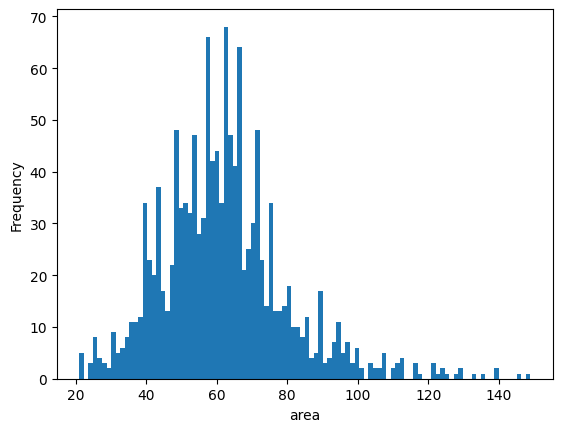

In [15]:
# checking the distribution of cell sizes
sp_object = sp_object.pp.add_observations("area")
_ = sp_object.pl.histogram("area", bins=100)

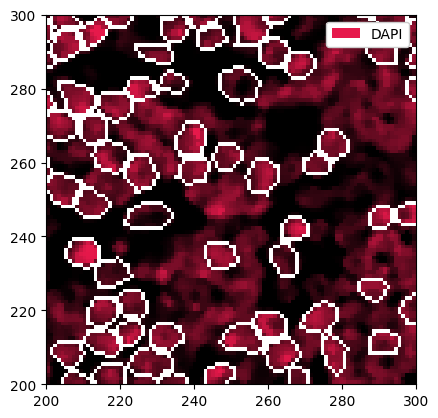

In [14]:
# filtering out cells with less than 20 or more than 150 pixels
sp_object = sp_object.pp.filter_by_obs('area', func=lambda x: (x > 20) & (x < 150))
# plotting the result
_ = sp_object.pp['DAPI'].pp[200:300, 200:300].pl.show(render_segmentation=True)

In [14]:
# expanding the masks
sp_object = sp_object.pp.grow_cells(iterations=2)

Mask growing requires recalculation of the observations. All features other than the centroids will be removed and should be recalculated with pp.add_observations().


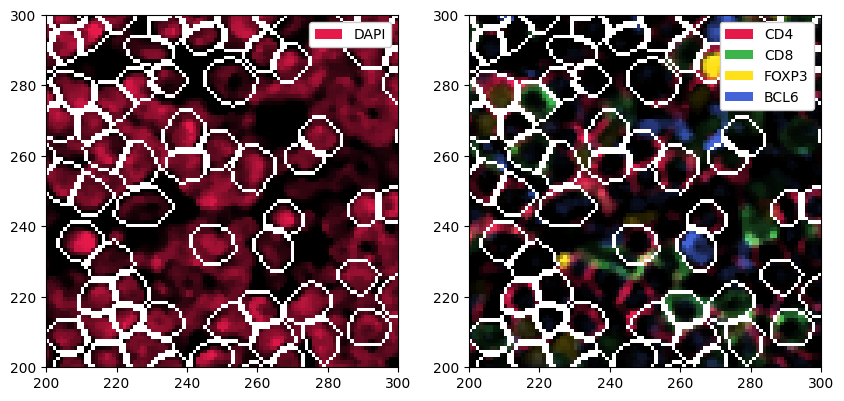

In [15]:
# plotting the resulting segmentation masks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
_ = sp_object.pp['DAPI'].pp[200:300, 200:300].pl.show(render_segmentation=True, ax=ax[0])
_ = sp_object.pp[['CD4', 'CD8', 'FOXP3', 'BCL6']].pp[200:300, 200:300].pl.show(render_segmentation=True, ax=ax[1])

## 4. Quantifying Protein Expression per Cell
Now that we have sensible segmentation masks, we can quantify the protein expression in each cell. There are multiple ways to do this, but taking the median intensity and then applying an arcsinh-transform has been proven to work pretty well.

In [16]:
sp_object = sp_object.pp.add_quantification(func=sp.pp.mean_intensity).pp.transform_expression_matrix(method='arcsinh')
sp_object

/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/skimage/measure/_regionprops.py:337: UserWarning: Extra property 'mean_intensity' is shadowed by existing property and will be inaccessible. Consider renaming it.
  warn(msg)


<xarray.Dataset>
Dimensions:                 (channels: 5, y: 500, x: 500, cells: 1320,
                             features: 2)
Coordinates:
  * channels                (channels) <U5 'DAPI' 'CD4' 'CD8' 'FOXP3' 'BCL6'
  * y                       (y) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * x                       (x) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * cells                   (cells) int64 1 2 3 4 5 ... 1316 1317 1318 1319 1320
  * features                (features) <U10 'centroid-0' 'centroid-1'
Data variables:
    _image                  (channels, y, x) float64 0.0 9.602e+03 ... 0.0 0.0
    _cellpose_segmentation  (y, x) uint16 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    _segmentation           (y, x) int64 0 0 0 0 0 10 10 10 ... 0 0 0 0 0 0 0 0
    _obs                    (cells, features) float64 1.85 41.85 ... 496.1 422.9
    _intensity              (cells, channels) float64 8.025 4.431 ... 1.26

As you can see, this introduced a new layer called `_intensity`. We can now use this to predict cell types.

## 5. Cell Type Prediction
There are several ways to predict cell types. Since we thresholded our data beforehand, we can simply take the argmax of the cell type specific channels to get an idea of the cell types we are looking at. Methods related to cell type prediction are all implemented in the label (la) module.

In [17]:
# this dictionary maps from cell types to markers
marker_dict = {'T_h': 'CD4', 'T_tox': 'CD8', 'T_reg': 'FOXP3', 'T_fh': 'BCL6'}
sp_object = sp_object.la.predict_cell_types_argmax(marker_dict)

/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [18]:
sp_object

<xarray.Dataset>
Dimensions:                 (labels: 4, props: 2, channels: 5, y: 500, x: 500,
                             cells: 1320, features: 3)
Coordinates:
  * labels                  (labels) int64 1 2 3 4
  * props                   (props) <U6 '_color' '_name'
  * channels                (channels) <U5 'DAPI' 'CD4' 'CD8' 'FOXP3' 'BCL6'
  * y                       (y) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * x                       (x) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * cells                   (cells) int64 1 2 3 4 5 ... 1316 1317 1318 1319 1320
  * features                (features) <U10 '_labels' 'centroid-0' 'centroid-1'
Data variables:
    _properties             (labels, props) object '#6A3A4C' 'T_fh' ... 'T_tox'
    _image                  (channels, y, x) float64 0.0 9.602e+03 ... 0.0 0.0
    _cellpose_segmentation  (y, x) uint16 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    _segmentation           (y, x) int64 0 0 0 0 0 10 10 10 ... 0 0 0 0 0 0 0 0
    _obs                    (cells, features) float64 4.0 1.85 ... 496.1 422.9
    _intensity              (cells, channels) float64 8.025 4.431 ... 1.26

This added a couple of things. For one, `_obs` now contains a feature called `_labels`. Furthermore, the `_properties` layer assigns each cell type to a color, which can be useful for plotting.

## 6. Plotting
Finally, let's do some plotting of the predicted cell types next to the markers. Before plotting, we can set some colors for the cell types (labels).

In [19]:
# setting the colors for the cell types
sp_object = sp_object.la.set_label_colors(['T_h', 'T_tox', 'T_reg', 'T_fh'], ['red', 'green', 'yellow', 'blue'])

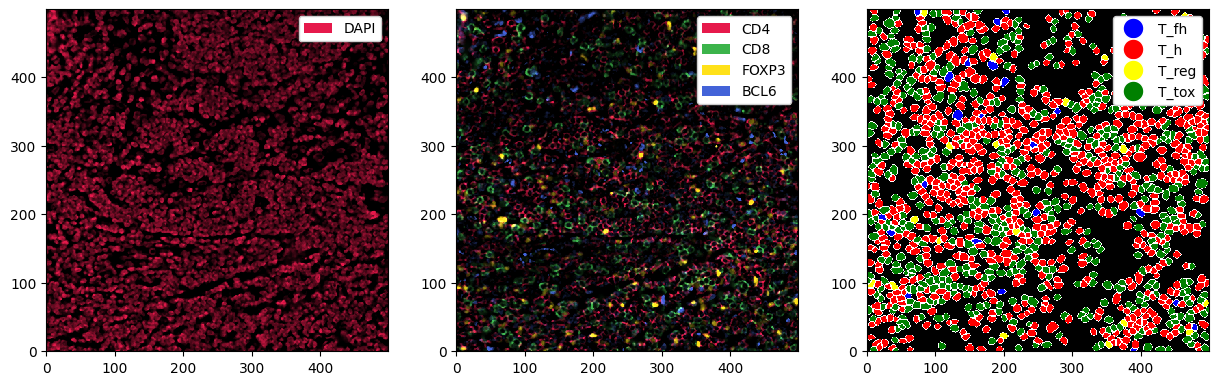

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
_ = sp_object.pp['DAPI'].pl.show(ax=ax[0])
_ = sp_object.pp[['CD4', 'CD8', 'FOXP3', 'BCL6']].pl.show(ax=ax[1])
_ = sp_object.pl.show(render_image=False, render_segmentation=True, render_labels=True, ax=ax[2])

And this is how easy it can be to perform analysis of highly multiplexed immunofluorescence images! If you have any additional questions, check out the other notebooks for details.